## Introduction
In this guide we will go through the process of loading a state-of-the-art, 1000-class image classifier, ResNet50V.We will be using it as a fixed feature extractor to train a smaller custom classifier on our own images.

We will first load ResNet50V2 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.

In [42]:
# Importing necessary libraries
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset CalTech-101, which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000. 

In [43]:
root = 'dataset'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['dataset\\accordion', 'dataset\\anchor', 'dataset\\ant', 'dataset\\barrel', 'dataset\\bass', 'dataset\\beaver', 'dataset\\binocular', 'dataset\\bonsai', 'dataset\\brain', 'dataset\\brontosaurus', 'dataset\\buddha', 'dataset\\butterfly', 'dataset\\camera', 'dataset\\cannon', 'dataset\\car_side', 'dataset\\ceiling_fan', 'dataset\\cellphone', 'dataset\\chair', 'dataset\\chandelier', 'dataset\\cougar_body', 'dataset\\cougar_face', 'dataset\\crab', 'dataset\\crayfish', 'dataset\\crocodile', 'dataset\\crocodile_head', 'dataset\\cup', 'dataset\\dalmatian', 'dataset\\dollar_bill', 'dataset\\dolphin', 'dataset\\dragonfly', 'dataset\\electric_guitar', 'dataset\\elephant', 'dataset\\emu', 'dataset\\euphonium', 'dataset\\ewer', 'dataset\\ferry', 'dataset\\flamingo', 'dataset\\flamingo_head', 'dataset\\garfield', 'dataset\\gerenuk', 'dataset\\gramophone', 'dataset\\grand_piano', 'dataset\\hawksbill', 'dataset\\headphone', 'dataset\\hedgehog', 'dataset\\helicopter', 'dataset\\ibis', 'dataset\\inlin

In [44]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [45]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [46]:
# Shyffling the data in order to adequately spread ever image throughou tthe dataset
random.shuffle(data)

In [47]:
# Splitting the dataset between train, validation and test set
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [50]:
# Defining the label and the features
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

In [53]:
x_train.shape

(4346, 224, 224, 3)

In [52]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [54]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Viewing the images

[]

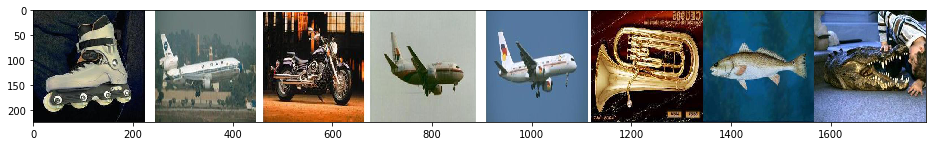

In [10]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.plot()

#### Building Model from Scratch
Building a convolutional network layer with two convolution and max-pooling layer while having no dropout layer <br>
The two convolution layer consists of convolution and activation layer. In the end of each convolution layer MaxPooling layer is added to reduce the complexity of the features. Both concolution layer consists of 32 neurons. The activation function used in convolution layers is the 'relu'. After having applied the convolution layer we convert it into single vector using Flatten(). The last layer is Dense() having the neurons equal to the number of our classes. The last activation function used is the 'softmax'.

In [82]:
# Training model with two convolution layer with no dropout layer
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model1.add(Dense(256))
model1.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_34 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_35 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)

To calculate loss we use 'categorical_crossentropy' and the optimizer used is 'adam' optimizer. <br>
Batch size is 64 while processing over 10 epoch cycles.


In [56]:
# Fitting the data 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 171s 39ms/step - loss: 4.2194 - accuracy: 0.1397 - val_loss: 3.4575 - val_accuracy: 0.2782
Epoch 2/10
4346/4346 [==============================] - 162s 37ms/step - loss: 2.2971 - accuracy: 0.4959 - val_loss: 2.7586 - val_accuracy: 0.4103
Epoch 3/10
4346/4346 [==============================] - 117s 27ms/step - loss: 0.5235 - accuracy: 0.8803 - val_loss: 2.9776 - val_accuracy: 0.4082
Epoch 4/10
4346/4346 [==============================] - 83s 19ms/step - loss: 0.0593 - accuracy: 0.9924 - val_loss: 3.3346 - val_accuracy: 0.4415
Epoch 5/10
4346/4346 [==============================] - 85s 19ms/step - loss: 0.0122 - accuracy: 0.9991 - val_loss: 3.3948 - val_accuracy: 0.4275
Epoch 6/10
4346/4346 [==============================] - 84s 19ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 3.4692 - val_accuracy: 0.4415
Epoch 7/10
4346/4346 [==============================] - 84s 19ms/step - lo

In [57]:
# Viewing the results on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.9562628750125737
Test accuracy: 0.42381975054740906


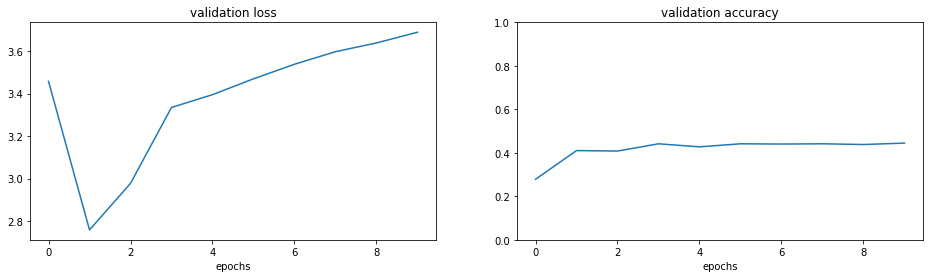

In [58]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

From the graphs presented above we can see the validation loss increasing as the epoch cycle increases in number because the model has started overfitting on the training data. The validation accuracy is nearly stagnant after the first epoch cycle.

In order to prevent the model from overfitting we make use of dropout layer. 

Building a convolutional network layer with two convolution and max-pooling layer while having a dropout layer

In [59]:
model1 = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model1.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.2))

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))

model1.add(Dropout(0.5))

model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_26 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_27 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_21 (Max

To calculate loss we use 'categorical_crossentropy' and the optimizer used is 'adam' optimizer. <br>
The batch_size is 64 while the number of epochs is same like previous which is 10.

In [60]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history1 = model1.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 105s 24ms/step - loss: 4.8337 - accuracy: 0.0334 - val_loss: 4.4961 - val_accuracy: 0.0956
Epoch 2/10
4346/4346 [==============================] - 104s 24ms/step - loss: 4.3415 - accuracy: 0.0725 - val_loss: 4.2207 - val_accuracy: 0.1450
Epoch 3/10
4346/4346 [==============================] - 104s 24ms/step - loss: 4.0289 - accuracy: 0.1309 - val_loss: 3.9505 - val_accuracy: 0.1772
Epoch 4/10
4346/4346 [==============================] - 104s 24ms/step - loss: 3.7443 - accuracy: 0.1680 - val_loss: 3.6440 - val_accuracy: 0.2030
Epoch 5/10
4346/4346 [==============================] - 104s 24ms/step - loss: 3.4866 - accuracy: 0.2025 - val_loss: 3.4396 - val_accuracy: 0.2589
Epoch 6/10
4346/4346 [==============================] - 104s 24ms/step - loss: 3.1157 - accuracy: 0.2591 - val_loss: 3.2856 - val_accuracy: 0.2750
Epoch 7/10
4346/4346 [==============================] - 104s 24ms/step 

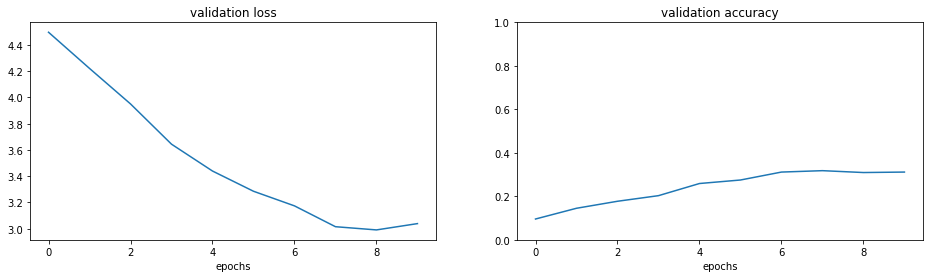

In [61]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history1.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history1.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

from the above graphs we can notice the gradual decrease in the validation loss till 8 epoch cyles and the model is no more overfitting on the training data as the number of epoch cycles increases while there is steady increase in accuracy which becoms nearly stagnant after 6 epoch cycles. <br>
As far as the accuracy is concerned, when compared with above model we notice a decrease. Thus the model has less accuracy.


In [62]:
loss, accuracy = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.05964776477077
Test accuracy: 0.30686694383621216


#### Loading a pre-trained network
Here we are using ResNet50V2.

In [19]:
res_net = keras.applications.ResNet50V2(weights='imagenet', include_top=True)
res_net.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

From the model summary above we can notice all the layers that has been used to build the ResNet50V2 model.

In [20]:
# make a reference to ResNet input layer
inp = res_net.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in ResNet, and make a reference to it
out = new_classification_layer(res_net.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Keeping all the layers frozen while only letting the last layer to be trained

In [70]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Keeping the batch size 128 while training over 10 epoch cycles.

In [22]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 523s 120ms/step - loss: 2.7200 - accuracy: 0.4542 - val_loss: 0.9523 - val_accuracy: 0.7669
Epoch 2/10
4346/4346 [==============================] - 521s 120ms/step - loss: 0.6505 - accuracy: 0.8921 - val_loss: 0.5406 - val_accuracy: 0.8518
Epoch 3/10
4346/4346 [==============================] - 520s 120ms/step - loss: 0.3250 - accuracy: 0.9478 - val_loss: 0.4876 - val_accuracy: 0.8528
Epoch 4/10
4346/4346 [==============================] - 518s 119ms/step - loss: 0.2060 - accuracy: 0.9770 - val_loss: 0.4524 - val_accuracy: 0.8657
Epoch 5/10
4346/4346 [==============================] - 520s 120ms/step - loss: 0.1443 - accuracy: 0.9869 - val_loss: 0.4448 - val_accuracy: 0.8657
Epoch 6/10
4346/4346 [==============================] - 520s 120ms/step - loss: 0.1068 - accuracy: 0.9956 - val_loss: 0.4308 - val_accuracy: 0.8668
Epoch 7/10
4346/4346 [==============================] - 520s 120m

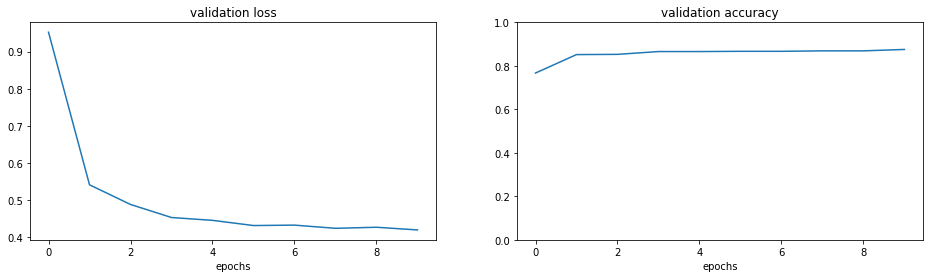

In [23]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

From the graph it is noticable that validation loss decreases and becomes consistent after 5 epoch cycles while the accuracy beccoms stagnant after the 1st epoch cycle. <br>
When compared to the model created from scratch we notice a tremendous increase in the accyuracy of the model while decent decrease in the validation loss. Infact the test accuracy has improved by a great margin. Thus the model performsa a lot better.

In [24]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.32437502212278835
Test accuracy: 0.9012875556945801


Creating a model having two layers trainable.

In [63]:
# make a reference to ResNet input layer
inp = res_net.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in ResNet, and make a reference to it
out = new_classification_layer(res_net.layers[-2].output)

# create a new network between inp and out
model_new1 = Model(inp, out)

In [71]:
# make all layers untrainable by freezing weights (except for two layers)
for l, layer in enumerate(model_new1.layers[:-2]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new1.layers[-2:]):
    layer.trainable = True

model_new1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
history3 = model_new1.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 753s 173ms/step - loss: 2.7467 - accuracy: 0.4439 - val_loss: 0.8854 - val_accuracy: 0.7863
Epoch 2/10
4346/4346 [==============================] - 528s 122ms/step - loss: 0.6170 - accuracy: 0.8948 - val_loss: 0.5067 - val_accuracy: 0.8625
Epoch 3/10
4346/4346 [==============================] - 528s 122ms/step - loss: 0.3030 - accuracy: 0.9542 - val_loss: 0.4503 - val_accuracy: 0.8743
Epoch 4/10
4346/4346 [==============================] - 526s 121ms/step - loss: 0.1912 - accuracy: 0.9814 - val_loss: 0.4176 - val_accuracy: 0.8894
Epoch 5/10
4346/4346 [==============================] - 528s 121ms/step - loss: 0.1355 - accuracy: 0.9899 - val_loss: 0.4036 - val_accuracy: 0.8851
Epoch 6/10
4346/4346 [==============================] - 528s 122ms/step - loss: 0.0972 - accuracy: 0.9952 - val_loss: 0.3898 - val_accuracy: 0.8958
Epoch 7/10
4346/4346 [==============================] - 529s 122m

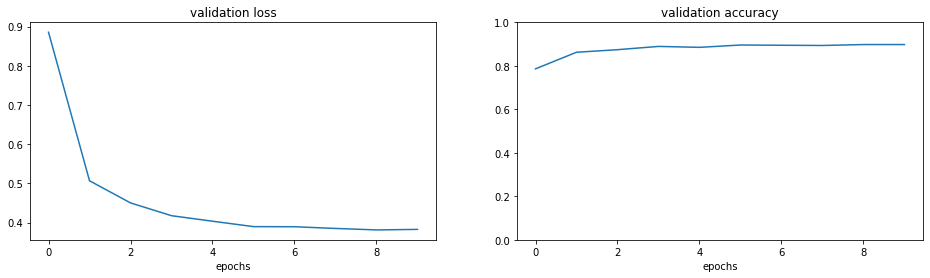

In [66]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [67]:
loss, accuracy = model_new1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3542943174746927
Test accuracy: 0.8980686664581299


When both the above models are compared we can notice that when two layers are unfreezed their is very slight decrease in test accuracy and the test loss is greater when compared to the model with one layer not frozen. On the other hand when looking at the validation accuracy then we see an increase in the second model with two unfrozen layer while the there is decrease in validation loss.<br>
Overall comparing the model built from scratch with the model built using ResNet50V2, we notice tremendous increase in the accuracy while significant decrease in the test loss, thus proving the model built using ResNet50V2 is significantly better.

### Data Augmentation

Here we make use of necessary data augmentation techniques in order to enhance the model. Data Augmentation helps a great deal when we have less amount of data. We use ImageDataGenerator for data augmentation process. As the data is less, we make use of 'rotation_range' in order to view the image from a different angle. 'width_shift_range' and 'height_shift_range' helps to randomly translate pictures vertically or horizontally. 'zoom_range' helps to randomly zoom in pictures. 'horizontal_flip' is for randomly flipping half of the images horizontally. the 'fill_mode' is basically used to fill the newly created pixels using nearest pixels. All these features helps to look the images in a different manner thus collecting more data from less data just by changing certain attributes.

In [68]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")


In [74]:
# make a reference to ResNet input layer
inp = res_net.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in ResNet, and make a reference to it
out = new_classification_layer(res_net.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [75]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
history4 = model_new.fit_generator(
    aug.flow(x_train, y_train, batch_size=10),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // 10,
    epochs=10)

Epoch 1/10
434/434 [==============================] - 388s 894ms/step - loss: 1.7609 - accuracy: 0.6054 - val_loss: 0.5262 - val_accuracy: 0.8443
Epoch 2/10
434/434 [==============================] - 387s 892ms/step - loss: 0.6362 - accuracy: 0.8406 - val_loss: 0.4898 - val_accuracy: 0.8636
Epoch 3/10
434/434 [==============================] - 388s 895ms/step - loss: 0.5062 - accuracy: 0.8628 - val_loss: 0.4661 - val_accuracy: 0.8883
Epoch 4/10
434/434 [==============================] - 388s 893ms/step - loss: 0.4321 - accuracy: 0.8768 - val_loss: 0.4892 - val_accuracy: 0.8915
Epoch 5/10
434/434 [==============================] - 388s 893ms/step - loss: 0.3755 - accuracy: 0.8872 - val_loss: 0.4527 - val_accuracy: 0.8947
Epoch 6/10
434/434 [==============================] - 387s 892ms/step - loss: 0.3468 - accuracy: 0.8994 - val_loss: 0.4759 - val_accuracy: 0.8937
Epoch 7/10
434/434 [==============================] - 387s 893ms/step - loss: 0.3147 - accuracy: 0.9045 - val_loss: 0.5105 -

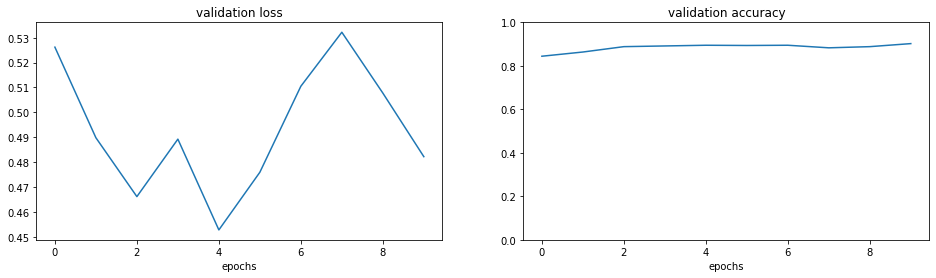

In [77]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [80]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4510069916688321
Test accuracy: 0.8927038908004761


From the obtained graph and output we can notice that the model created using data augmentation technique has performed somewhat similar to the other two models trained using resnet. There has not been much of a difference in the output. Provided if the model is trained for longer epoch cycles, maybe the difference could have been noticable, but for 10 epochs all three model built using ResNet has performed somewhat similar.